# Topi Model
- Latent Dirichlet Allocation (LDA)

In [5]:
!pip install watermark
!pip install japanize-matplotlib==1.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=7bf9539585c34ab9f314f590b6d2a25405adc952c20e344a088535d1befb71a4
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [10]:
#@title import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import japanize_matplotlib

import tensorflow_probability as tfp
import tensorflow as tf
tfb = tfp.bijectors
tfd = tfp.distributions

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
colors = sns.color_palette('tab10')
japanize_matplotlib.japanize()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [11]:
#@title utility function
def format_trace(states, var_name, chain_dim=None):
    if chain_dim is None:
        # chainが１つだと明示するためaxisを追加
        trace = {k: v[tf.newaxis].numpy() for k, v in zip(var_name, states)}
    else:
        # axis0がchainの次元になるようにする
        trace = {k: np.swapaxes(v.numpy(), chain_dim, 0) for k, v in zip(var_name, states)}
    # from_tfpもあるが、実行するとeager_executionがオフにされてしまうなど現状使いづらいので、from_dictを用いている
    return az.from_dict(trace)


Document
['モバイル', 'PC', '投票', 'ドラマ', '監督', 'ボール', '投票', '補欠', '投票', '補欠', '辞任', '議員', '演じる', '勝敗', 'PC', '辞任', '会見', 'ボール', '議員', '議員', 'サッカー', 'ゲーム', '俳優', '議員', 'テニス', 'PC', '会見', '会見', '会見', '演じる', '打つ', '演じる', '選手', '会見', 'ドラマ', 'モバイル', '選手', 'サッカー', '勝敗', '選手', 'サッカー', '投票', '監督', 'テニス', 'サッカー', '辞任', '補欠', '選手', 'PC', '会見', '走る', '選手', '会見', '勝敗', '会見', '補欠', 'テニス', 'ゲーム', '議員', 'サッカー', 'ボール', 'サッカー', 'サッカー', 'オリンピック', '俳優', 'ゲーム', '演じる', '俳優', '会見', 'ボール', 'サッカー', '補欠', 'ドラマ', 'テニス', '選手', '監督', 'PC', 'サッカー', '勝敗', '会見']

Bag of words
[('会見', 10), ('サッカー', 9), ('選手', 6), ('PC', 5), ('補欠', 5), ('議員', 5), ('投票', 4), ('ボール', 4), ('演じる', 4), ('勝敗', 4), ('テニス', 4), ('ドラマ', 3), ('監督', 3), ('辞任', 3), ('ゲーム', 3), ('俳優', 3), ('モバイル', 2), ('打つ', 1), ('走る', 1), ('オリンピック', 1)]


Text(0, 0.5, 'number of words')

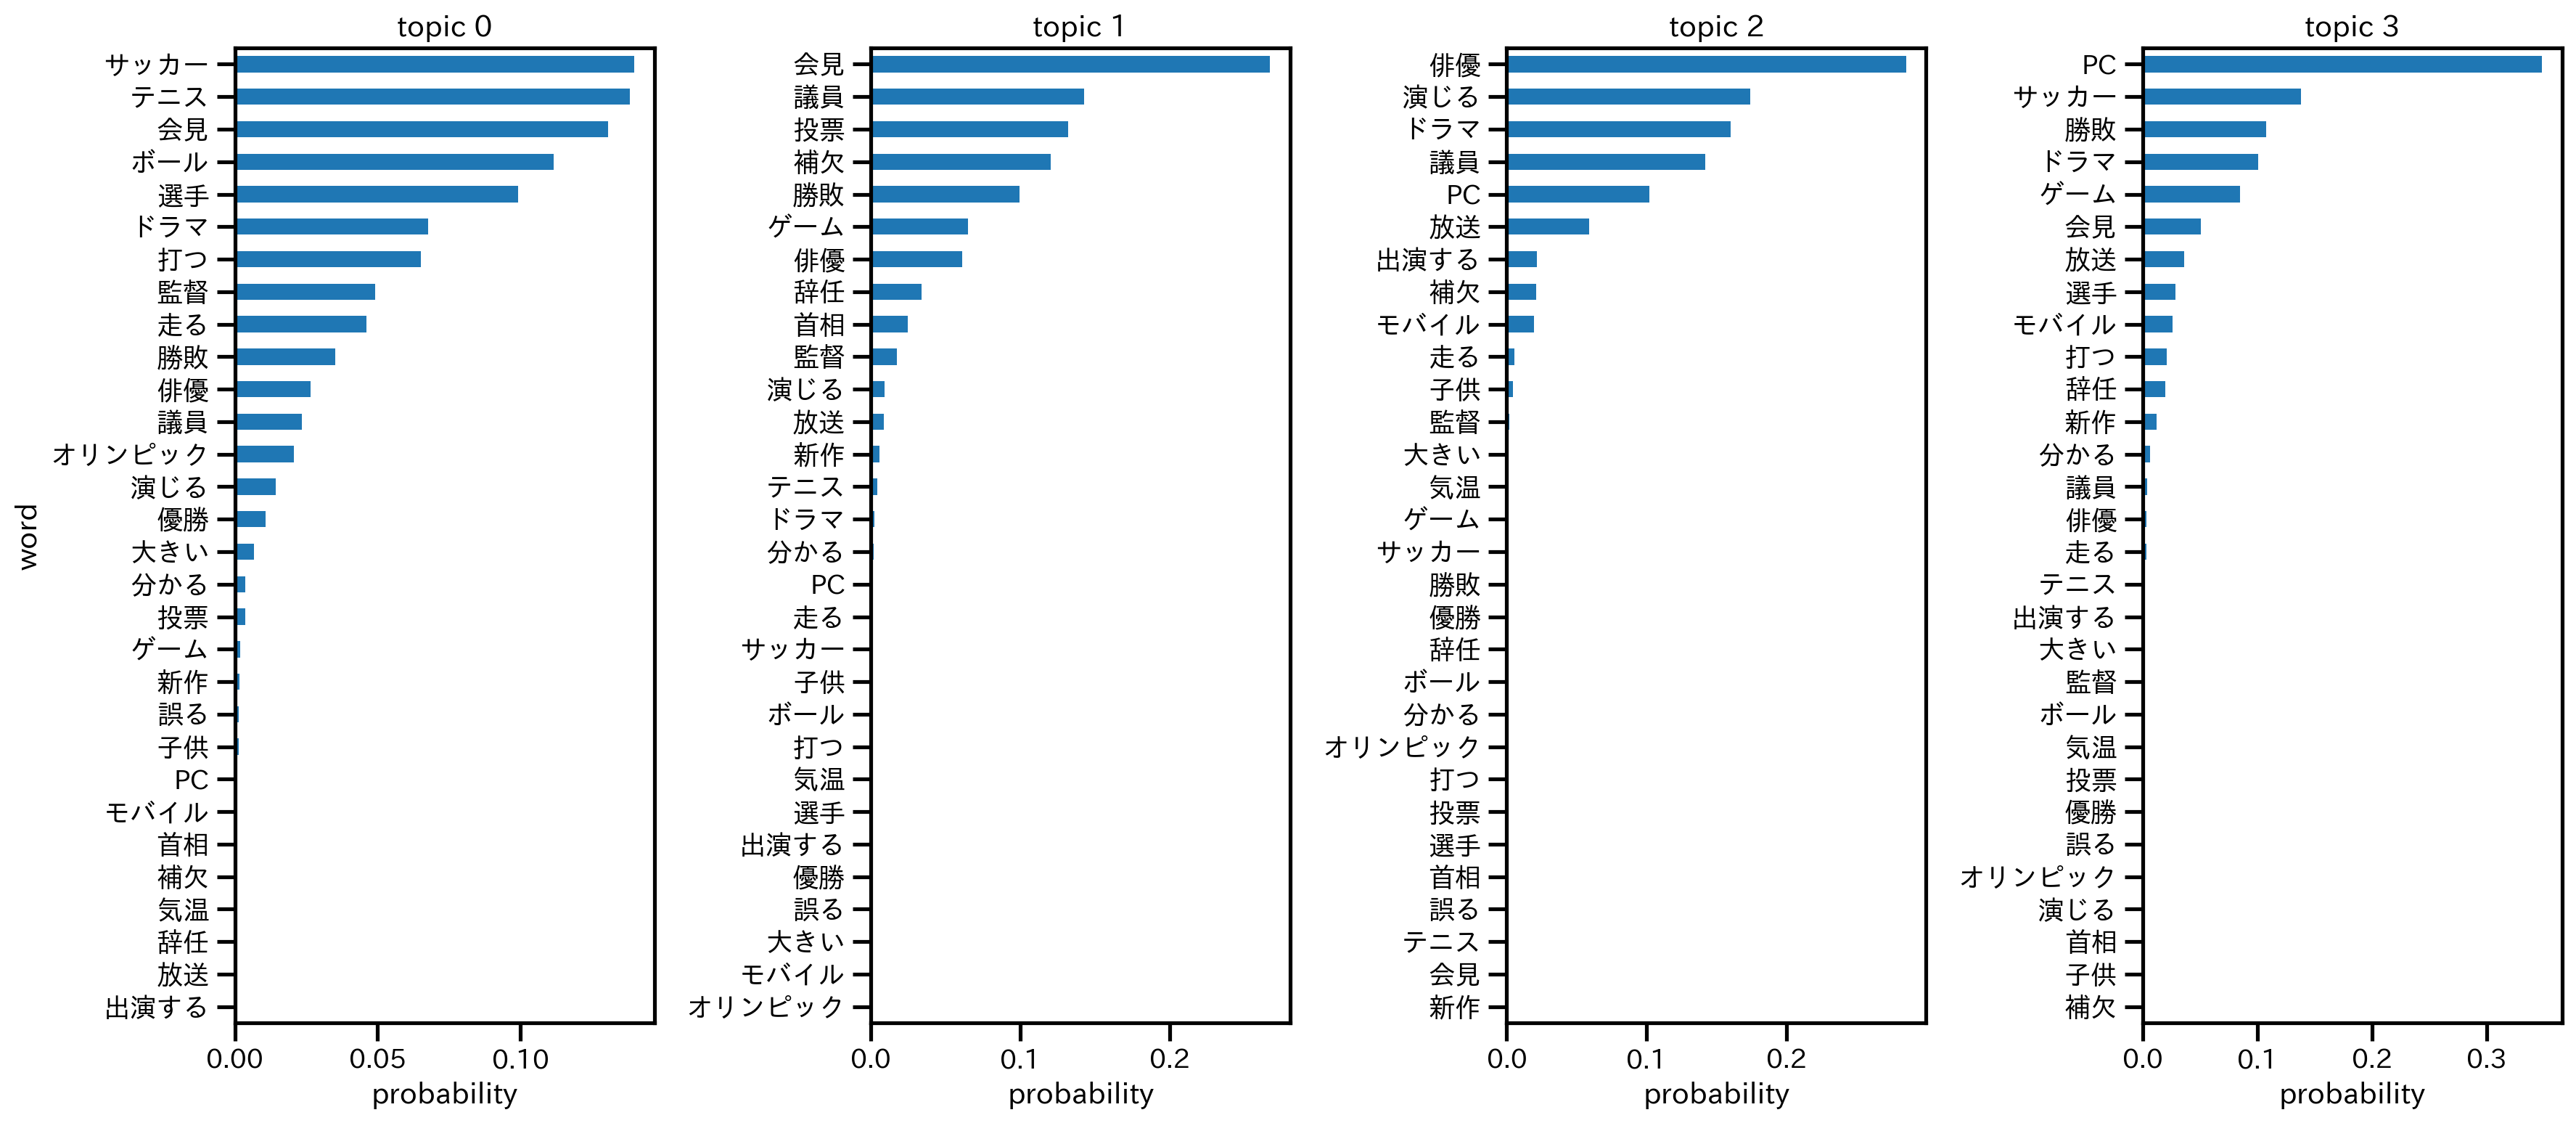

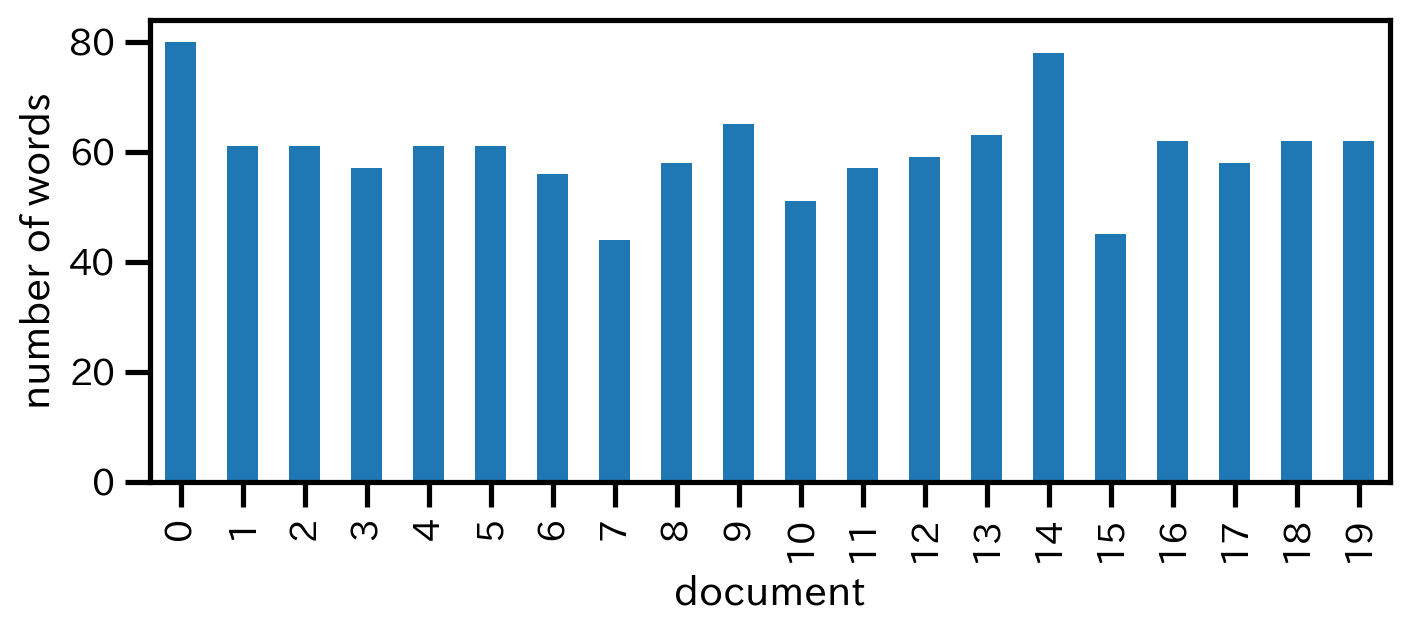

In [13]:

K = 4
V = 30
M = 20

# 事前分布のパラメータ
alpha = np.ones(K) * 0.8
beta = np.ones(V) * 0.2

np.random.seed(2)
# θを事前分布からサンプリング
topic_dist = np.random.dirichlet(alpha, size=M)
# φを事前分布からサンプリング
word_dist = np.random.dirichlet(beta, size=K)

# 文書あたりの単語数はポアソン分布に従うとする
avg_doc_len = 60
N = np.random.poisson(avg_doc_len, M)

documents = []
for i in range(M):
    # モデル式に従い、単語をサンプリング
    topics = np.random.choice(K, p=topic_dist[i], size=N[i])
    words = [np.random.choice(V, p=word_dist[j]) for j in topics]
    documents.append(words)

sports = ['サッカー', 'テニス', 'ボール', '選手', '打つ', '監督', '走る', 'オリンピック', '優勝']
politics = ['会見', '議員', '投票', '補欠', '辞任', '首相', '答える', '自民党', '表明する']
entertainment = ['俳優', '演じる', 'ドラマ', '放送', '出演する', '人気', '舞台', 'スクープ', 'テレビ']
technology = ['PC', '勝敗', 'ゲーム', 'モバイル', '新作', '発売する', '電源', 'インストール']
word_lists = [sports, politics, entertainment, technology]

id2word = {i: '' for i in range(V)}

word_id_topic_prob = sorted(zip(range(V), word_dist.argmax(axis=0), word_dist.max(axis=0)), key=lambda x: x[2], reverse=True)
for i in word_id_topic_prob[:25]:
    id2word[i[0]] = word_lists[i[1]].pop(0)

random_words = ['大きい', '誤る', '気温', '子供', '分かる']
for i in id2word:
    if id2word[i] == '':
        id2word[i] = random_words.pop()

with open('vocab.txt', 'w') as f:
    for w in id2word.values():
        f.write(w + '\n')

with open('vocab.txt') as f:
   words = f.read().split()

# key: 単語ID, value: 単語
id2word = {i: j for i, j in enumerate(words)}

doc = [id2word[x] for x in documents[0]]
print('Document')
print(doc)

from collections import Counter
print('\nBag of words')
# 単語の出現回数を数え、回数が多い順に表示
print(Counter(doc).most_common())

fig, axes = plt.subplots(1, K, figsize=(18, 8))
for i in range(K):
    ax = axes[i]
    s = pd.Series(word_dist[i]).sort_values()
    s.index = s.index.map(id2word)
    s.plot.barh(ax=ax)
    ax.set_title(f'topic {i}')
    ax.set_xlabel('probability')
    if i == 0:
        ax.set_ylabel('word')
plt.tight_layout()

plt.figure(2)
pd.Series(N).plot.bar(figsize=(8, 3))
plt.xlabel('document')
plt.ylabel('number of words')

## Make samples
- Bag-of-Words
- topic assignment : $z_{d_i}|\theta_d$ ~ $Cat(\theta_d)$
- Probability of word occurence in Topic "k" : $w_{d_i}|z_{d_i}$, $\Phi$ ~ Cat($\Phi_{z_{d,i}}$)
- K : num of topics, D:num of documents, V:num of words

Document
['モバイル', 'PC', '投票', 'ドラマ', '監督', 'ボール', '投票', '補欠', '投票', '補欠', '辞任', '議員', '演じる', '勝敗', 'PC', '辞任', '会見', 'ボール', '議員', '議員', 'サッカー', 'ゲーム', '俳優', '議員', 'テニス', 'PC', '会見', '会見', '会見', '演じる', '打つ', '演じる', '選手', '会見', 'ドラマ', 'モバイル', '選手', 'サッカー', '勝敗', '選手', 'サッカー', '投票', '監督', 'テニス', 'サッカー', '辞任', '補欠', '選手', 'PC', '会見', '走る', '選手', '会見', '勝敗', '会見', '補欠', 'テニス', 'ゲーム', '議員', 'サッカー', 'ボール', 'サッカー', 'サッカー', 'オリンピック', '俳優', 'ゲーム', '演じる', '俳優', '会見', 'ボール', 'サッカー', '補欠', 'ドラマ', 'テニス', '選手', '監督', 'PC', 'サッカー', '勝敗', '会見']

Bag of words
[('会見', 10), ('サッカー', 9), ('選手', 6), ('PC', 5), ('補欠', 5), ('議員', 5), ('投票', 4), ('ボール', 4), ('演じる', 4), ('勝敗', 4), ('テニス', 4), ('ドラマ', 3), ('監督', 3), ('辞任', 3), ('ゲーム', 3), ('俳優', 3), ('モバイル', 2), ('打つ', 1), ('走る', 1), ('オリンピック', 1)]


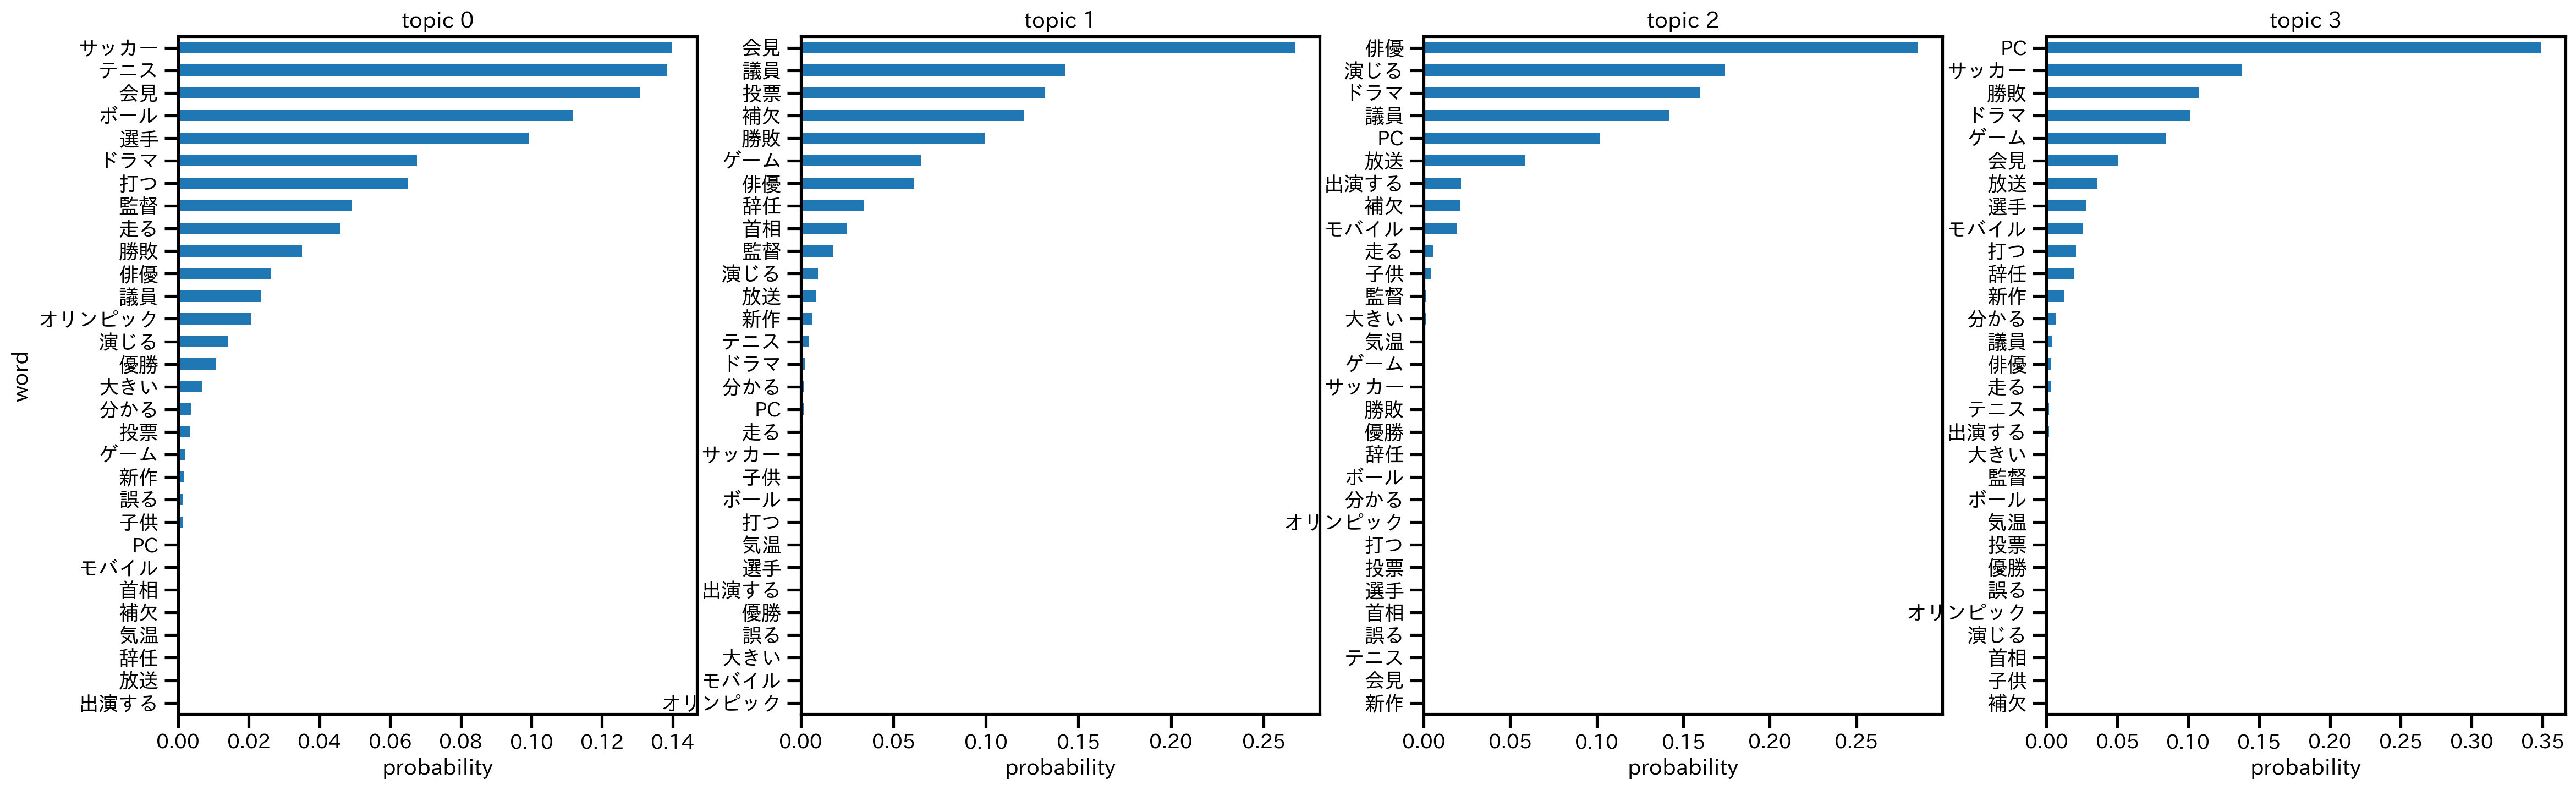

In [29]:
K=4 #num of topics
V=30 #num of words
M=20 #num of documents

#prior distribution
alpha = np.ones(K)*0.8
beta = np.ones(V)*0.2
np.random.seed(2)
#topic allocation
topic_dist = np.random.dirichlet(alpha,size=M) #4*20
#probability of word occurence ; Phi
word_dist = np.random.dirichlet(beta,size=K)

#num of words per document is based on poisson distribution
avg_doc_len = 60
N = np.random.poisson(avg_doc_len,M) #(20,)

documents = []
for i in range(M):
  #words sampling based on model
  topics = np.random.choice(K,p=topic_dist[i],size=N[i]) #generate topics
  words = [np.random.choice(V,p=word_dist[j]) for j in topics] #make documents based on topics
  documents.append(words)

#print documents
with open("vocab.txt") as f:
  words = f.read().split()
id2word = {i: j for i,j in enumerate(words)}
doc = [id2word[x] for x in documents[0]]
print("Document")
print(doc)
print("\nBag of words")
print(Counter(doc).most_common())

#check probability of word occurence for each topic
fig,axes = plt.subplots(1,K,figsize=(28,8))
for i in range(K):
  ax = axes[i]
  s = pd.Series(word_dist[i]).sort_values()
  s.index = s.index.map(id2word)
  #print(s)
  s.plot.barh(ax=ax)
  ax.set_title(f"topic {i}")
  ax.set_xlabel("probability")
  if i==0:
    ax.set_ylabel("word")

## Model definition
- model : LDA
- inference : HMC method
- tfd.MixtureSameFamily -> marginalize latent variables

In [36]:
Root = tfd.JointDistributionCoroutine.Root
def lda_model():
  #distribution of topics
  theta = yield Root(tfd.Independent(
      tfd.Dirichlet(concentration=tf.ones([M,K])),
      reinterpreted_batch_ndims=1,
      name="theta"
  )) #event shape : [M,K]
  #distribution of words for each topic
  phi = yield Root(tfd.Independent(
      tfd.Dirichlet(concentration=tf.ones([K,V])),
      reinterpreted_batch_ndims=1,
      name="phi"
  ))

  for m in range(M):
    #observation distribution
    y = yield tfd.Sample(
        #marginalize z which assign topics
        tfd.MixtureSameFamily(
            #theta
            mixture_distribution=tfd.Categorical(
                probs=theta[...,m,:]
            ), #Categories : K
            #phi
            components_distribution=tfd.Categorical(
                probs=phi
            ) #categories : V
        ),
        sample_shape=N[m],
        name=f"y_{m}" #event_shape:n, categories : V
    )

lda = tfd.JointDistributionCoroutine(lda_model)
def target_log_prob_fn(theta,phi):
  return lda.log_prob(theta,phi,*documents)

#inference
num_results = 1000
num_burnin_steps = 500
tf.random.set_seed(42)

#initialize params
initial_state = [
    tf.fill([M,K],value=1/K,name="theta"), #make tensor whose shape is [M,K] and value is 1/K
    tf.fill([K,V], value=1/V, name="phi")
]
#transformation of variables
#Category distribution -> softmax
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.SoftmaxCentered(),
]

#HMC : define sampling function
@tf.function(autograph=False)
def sample():
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=tfp.mcmc.SimpleStepSizeAdaptation( #automatically set hyperparameters : epsilon, L
          tfp.mcmc.TransformedTransitionKernel(
              inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                  target_log_prob_fn=target_log_prob_fn,
                  step_size=0.1,
                  num_leapfrog_steps=5
              ),
              bijector=unconstraining_bijectors
          ),
          num_adaptation_steps=400
      ),
      trace_fn=lambda _, pkr:pkr.inner_results.inner_results.is_accepted
      )

[theta,phi], is_accepted = sample()

print("acceptance rate: {:.1%}".format(is_accepted.numpy().mean()))

acceptance rate: 72.8%


## Check result

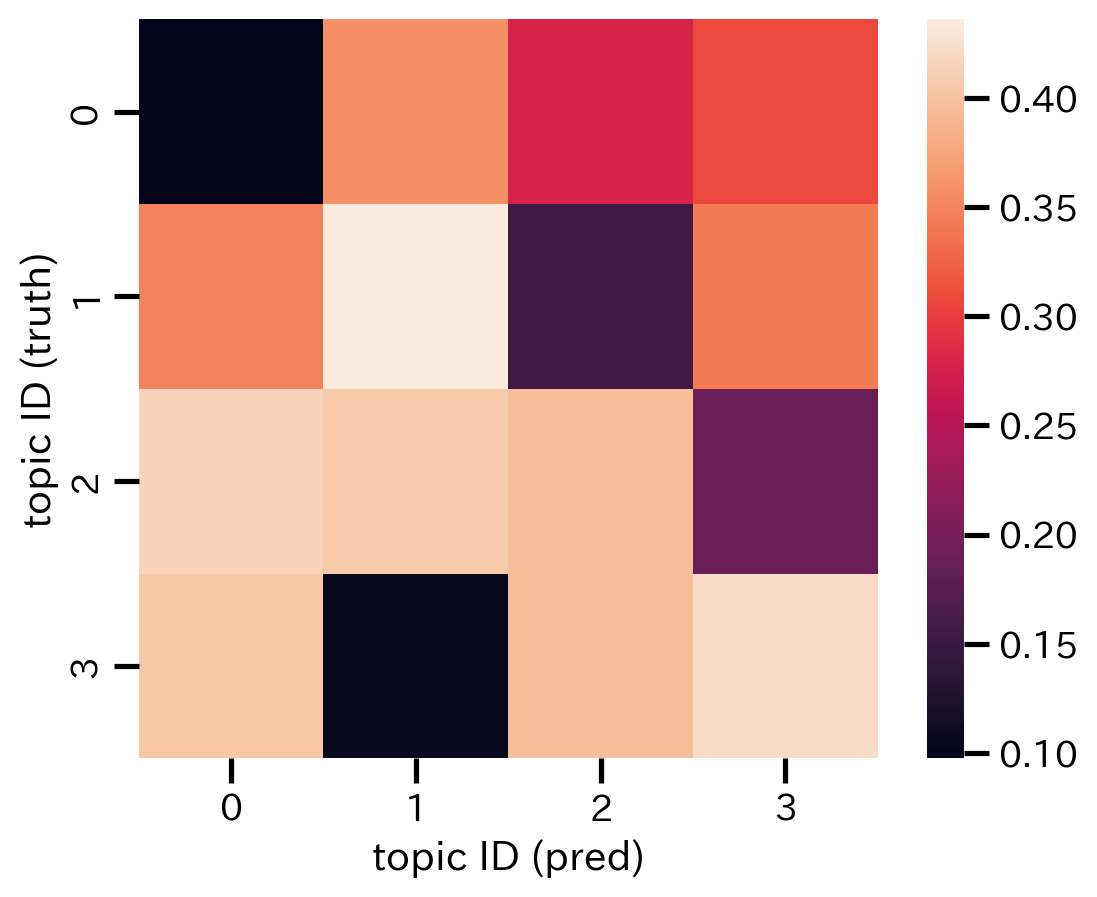

In [37]:
trace = format_trace([theta,phi],["theta","phi"])

from scipy.spatial import distance_matrix
dist_mat = distance_matrix(word_dist,np.mean(phi.numpy(),axis=0))
sns.heatmap(dist_mat,square=True)
plt.xlabel("topic ID (pred)")
plt.ylabel("topic ID (truth)")

permute_id = [dist_mat[i].argmin() for i in range(K)]
assert len(set(permute_id)) ==K

phi_p = phi.numpy()[:,permute_id,:]
theta_p = theta.numpy()[:,:,permute_id]

## Check Quality

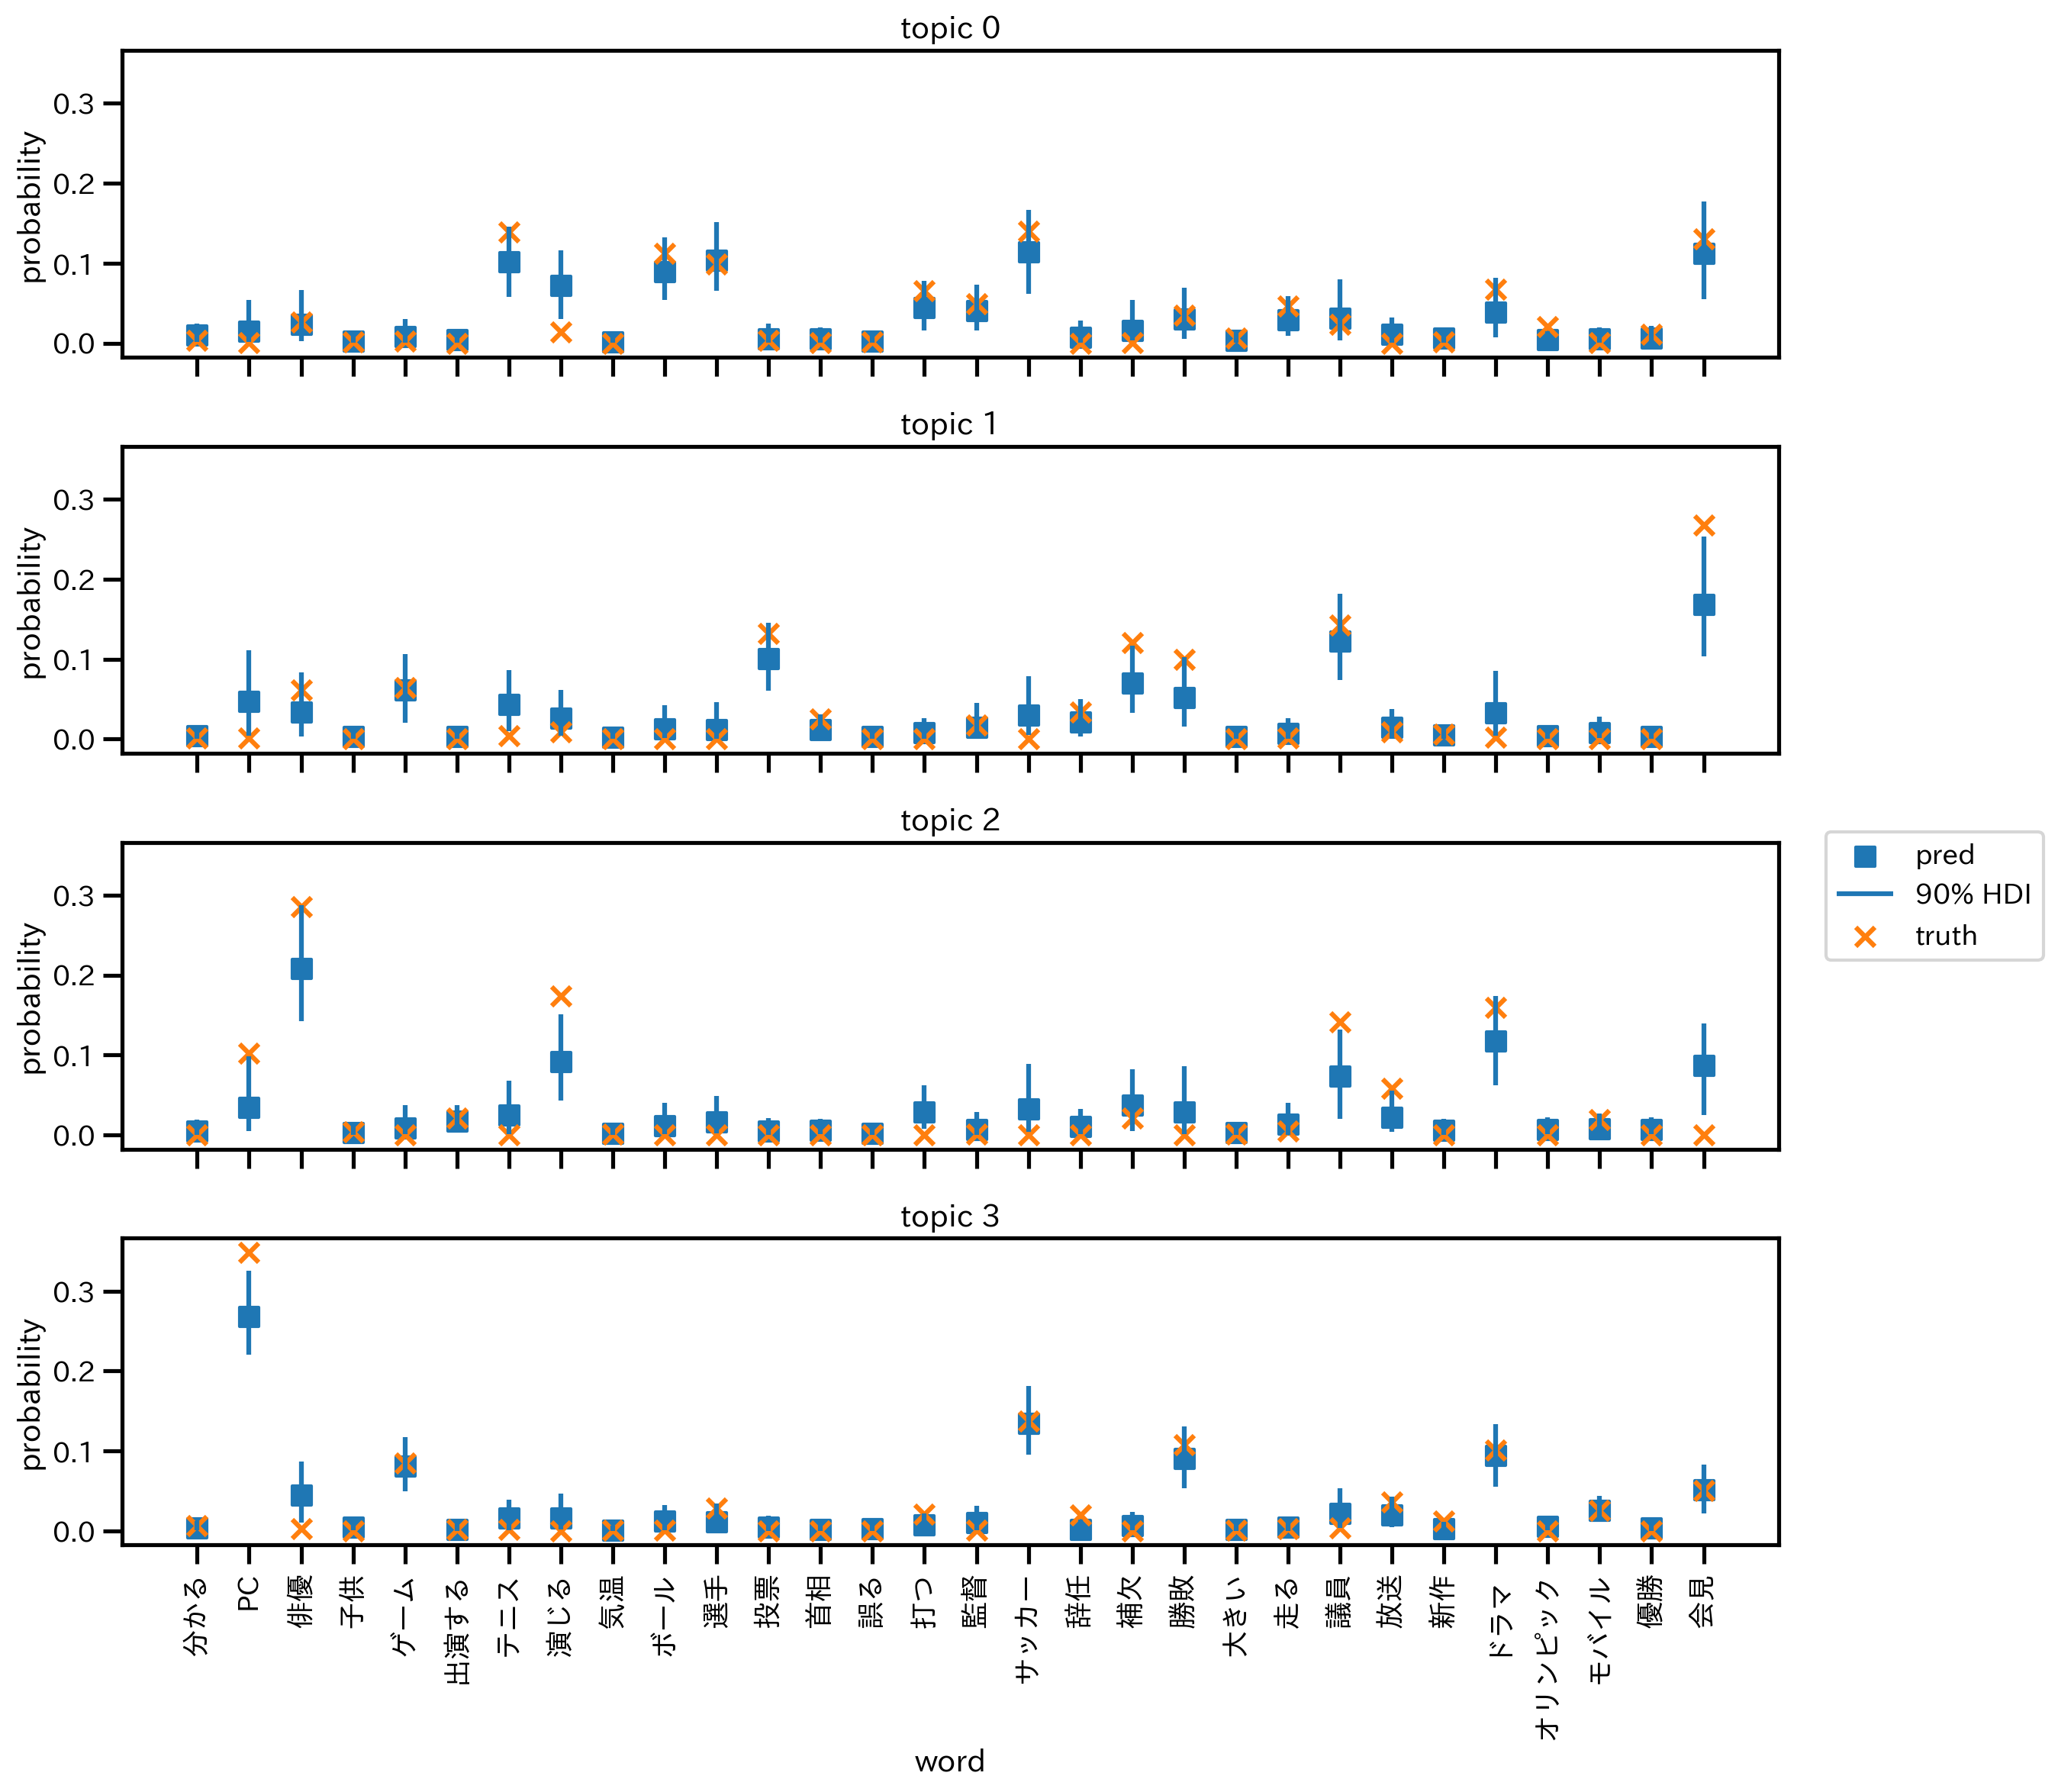

In [38]:
# (1 - a) x 100% のサンプルが入る区間を求める
a = 0.1
lwr, med, upr = np.quantile(phi_p, [a / 2, 0.5, 1 - a / 2], axis=0)

# 描画用
xticks = range(V)
vocabs = id2word.values()

fig, axes = plt.subplots(K, 1, sharex=True, sharey=True, figsize=(12, 3*K))

for i in range(K):
    ax = axes[i]
    ax.scatter(range(V), med[i], color=colors[0], marker='s', label='pred')
    ax.vlines(range(V), lwr[i], upr[i], color=colors[0], label=f'{1-a:.0%} HDI')
    ax.scatter(range(V), word_dist[i], color=colors[1], marker='x', label='truth')
    if i == K - 1:
        ax.set_xlabel('word')
    ax.set_ylabel('probability')
    ax.set_xticks(xticks)
    ax.set_xticklabels(vocabs, rotation=90)
    ax.set_title(f'topic {i}')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=[1.0, 0.5])
plt.tight_layout()

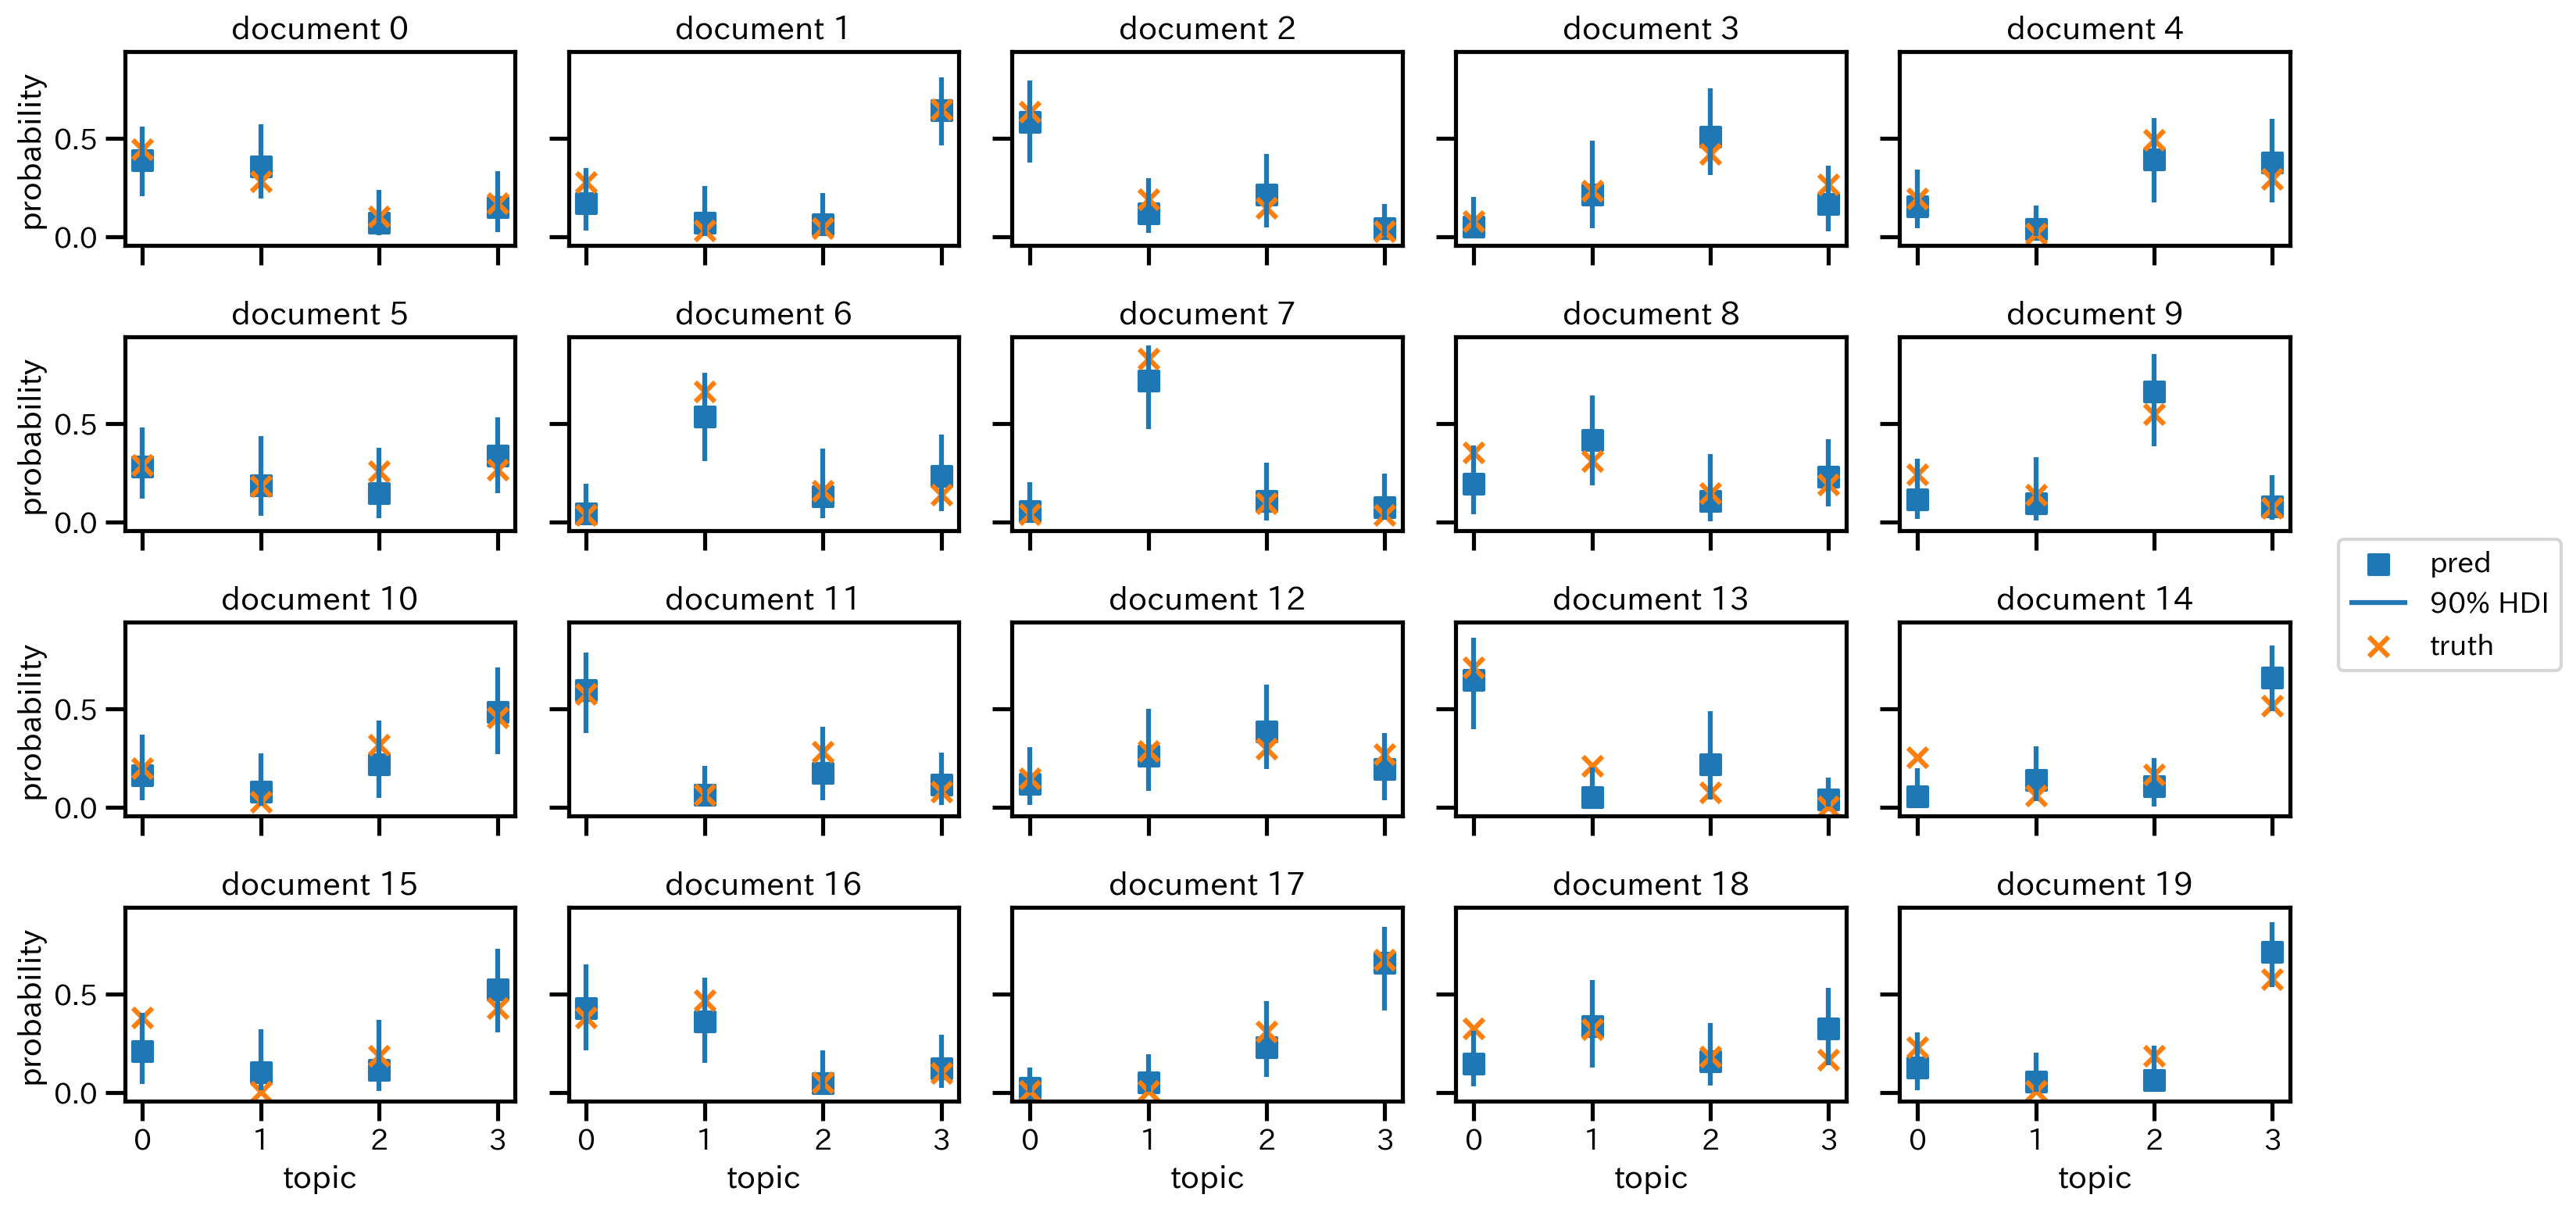

In [39]:
a = 0.1
lwr, med, upr = np.quantile(theta_p, [a / 2, 0.5, 1 - a / 2], axis=0)

ncol = 5
nrow = round(np.ceil(M/ncol))
fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(ncol*3, nrow*2))

for i in range(M):
    ax = axes.ravel()[i]
    ax.scatter(range(K), med[i], color=colors[0], marker='s', label='pred')
    ax.vlines(range(K), lwr[i], upr[i], color=colors[0], label=f'{1-a:.0%} HDI')
    ax.scatter(range(K), topic_dist[i], color=colors[1], marker='x', label='truth')
    # ax.legend()
    ax.set_xticks(range(K))
    if i >= ncol * (nrow-1):
        ax.set_xlabel('topic')
    if not i % ncol:
        ax.set_ylabel('probability')
    ax.set_title(f'document {i}')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=[1.0, 0.5])
plt.tight_layout()